In [54]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import keras
import pickle

from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.initializers import Ones, Zeros, Constant
from keras.models import Model, load_model
from keras.layers import Dense, Input, Lambda, SimpleRNN, Reshape, RepeatVector, PReLU,BatchNormalization
from keras.losses import mse
from keras.constraints import non_neg

In [55]:
# Change presentation settings

%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (16.0, 10.0)

#matplotlib.rcParams['font.family'] = 'sans-serif'
#matplotlib.rcParams['font.sans-serif'] = ['Liberation Sans']

matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.top"] = True
matplotlib.rcParams["axes.spines.right"] = True
matplotlib.rcParams["axes.spines.bottom"] = True
matplotlib.rcParams["axes.labelsize"] = 16
matplotlib.rcParams["axes.titlesize"] = 18

matplotlib.rcParams["xtick.top"] = True
matplotlib.rcParams["ytick.right"] = True
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
matplotlib.rcParams["xtick.labelsize"] = 10
matplotlib.rcParams["ytick.labelsize"] = 10
matplotlib.rcParams["xtick.major.size"] = 10
matplotlib.rcParams["ytick.major.size"] = 10
matplotlib.rcParams["xtick.minor.size"] = 5
matplotlib.rcParams["ytick.minor.size"] = 5
matplotlib.rcParams["xtick.minor.visible"] = True

matplotlib.rcParams["lines.linewidth"] = 2

matplotlib.rcParams["legend.fontsize"] = 14

color_palette = {"Indigo": {
                    50: "#E8EAF6",
                    100: "#C5CAE9",
                    200: "#9FA8DA",
                    300: "#7986CB",
                    400: "#5C6BC0",
                    500: "#3F51B5",
                    600: "#3949AB",
                    700: "#303F9F",
                    800: "#283593",
                    900: "#1A237E"},
                 "Orange": {      
                    50: "#FFF3E0",
                    100: "#FFE0B2",
                    200: "#FFCC80",
                    300: "#FFB74D",
                    400: "#FFA726",
                    500: "#FF9800",
                    600: "#FB8C00",
                    700: "#F57C00",
                    800: "#EF6C00",
                    900: "#E65100"}
                }

line_styles = [(0, ()), (0, (1, 2)), (0, (3, 2))]

In [56]:
def plot_loss(data, save_name=False):
    """Plots the training and validation loss"""
    fig, ax = plt.subplots()

    plt.xlabel("Epoch", horizontalalignment='right', x=1.0)
    plt.ylabel("Cross-entropy", horizontalalignment='right', y=1.0)

    plt.plot(data["loss"], linestyle=line_styles[0], color=color_palette["Indigo"][800])
    plt.plot(data["val_loss"], linestyle=line_styles[2], color=color_palette["Orange"][400])
    plt.legend(["Training data set", "Validation data set"], loc="upper right", frameon=False)
    #plt.yscale("log")
    
    if save_name:
        fig.savefig("%s/%s.eps" % (figure_export_directory, save_name), bbox_inches="tight")

    plt.show();

In [57]:
def train_nn(model, x, y, batch_size, loss, name, xval):

    adam = keras.optimizers.Adam(lr=0.003,
                                 beta_1=0.9,
                                 beta_2=0.999,
                                 epsilon=None,
                                 decay=0.0,
                                 amsgrad=False)

    early_stopper = EarlyStopping(monitor="val_loss",
                                  patience=32,
                                  verbose=True,
                                  mode="auto")

    reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                                  factor=0.1,
                                  patience=24)
    
    checkpoint_callback = ModelCheckpoint(("%s.h5" % (name)),
                                          monitor="val_loss",
                                          verbose=False,
                                          save_best_only=True,
                                          mode="min")
    
    model.compile(loss=loss, optimizer=adam)
    
    history = model.fit(x, y,
                     batch_size=batch_size,
                     epochs=1000,
                     verbose=2,
                     initial_epoch=0,
                     shuffle=True,
                     validation_data=(xval,xval),
                     callbacks=[early_stopper, checkpoint_callback])
    return history

## Data

In [58]:
runs = [304125,302263,304508]
with open("pileup_dataNotNorm.pickle", 'rb') as handle:
    data = pickle.load(handle)

x_train = np.array(data[str(runs[0])]['samples'])
x_val = np.array(data[str(runs[1])]['samples'])
x_test = np.array(data[str(runs[2])]['samples'])

WINDOW = 1
num_parts = 6

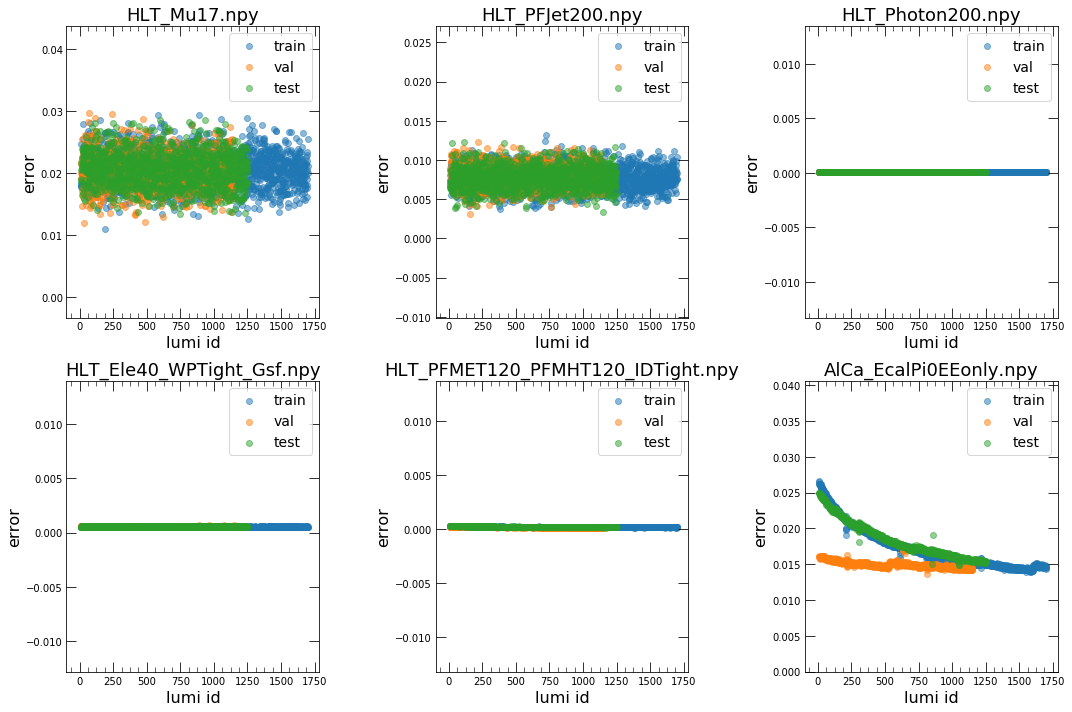

In [59]:
plots = [x_train,x_val,x_test]
titles = ["train","val","test"]

stuff = [[],[],[]]
lumi = [[],[],[]]
for h in range(3):
    labels = data['HLT'] 
    lumi[h] = data[str(runs[h])]['lumiid']
    stuff[h] = data[str(runs[h])]['rates']
    
plt.figure(figsize=[15,10])
              
for i in range(num_parts):
    plt.subplot(2,3,i+1)
    for k in range(0,3):
        #print(len(lumi[k]),len(stuff[k][i]))
        plt.scatter(lumi[k],stuff[k][i],label=titles[k],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()
plt.show()

In [60]:
runs = [304125,304508,302263]

with open('pileup_dataNotNorm.pickle', 'rb') as handle:
    data = pickle.load(handle)
with open('pileup_bad_dataNotNorm.pickle', 'rb') as handle:
    bad_data = pickle.load(handle)

x_train = np.array(data[str(runs[0])]['samples'])
x_val = np.array(data[str(runs[1])]['samples'])
x_test = np.array(data[str(runs[2])]['samples'])

x_bad = np.array(bad_data['301480']['samples'])

WINDOW = 1

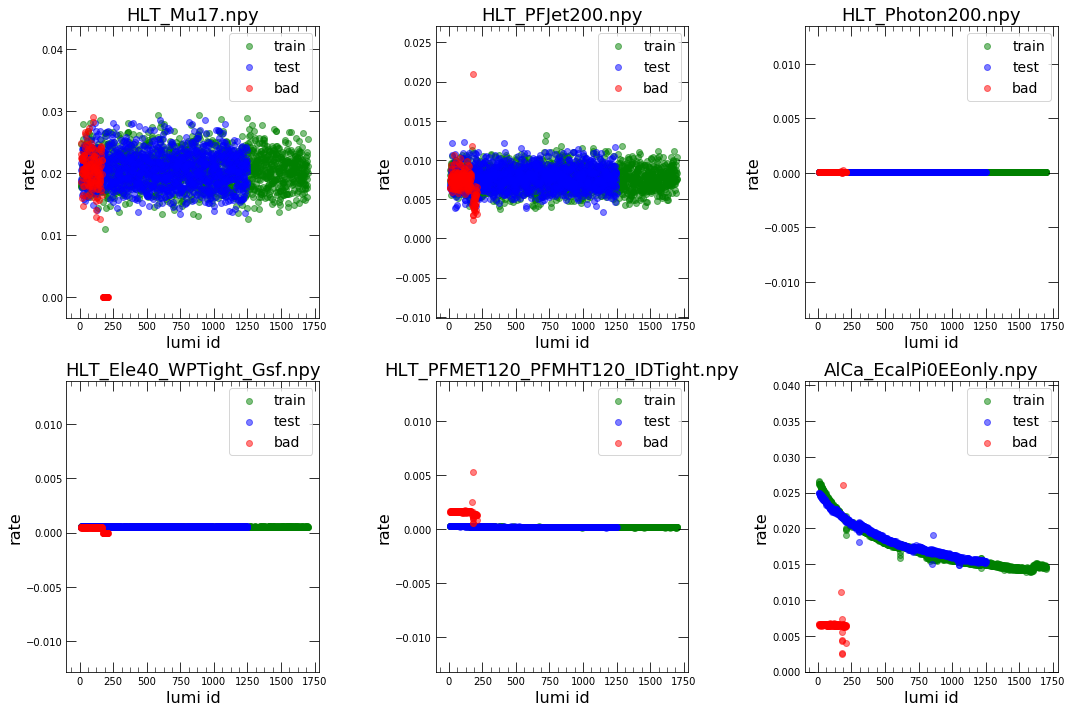

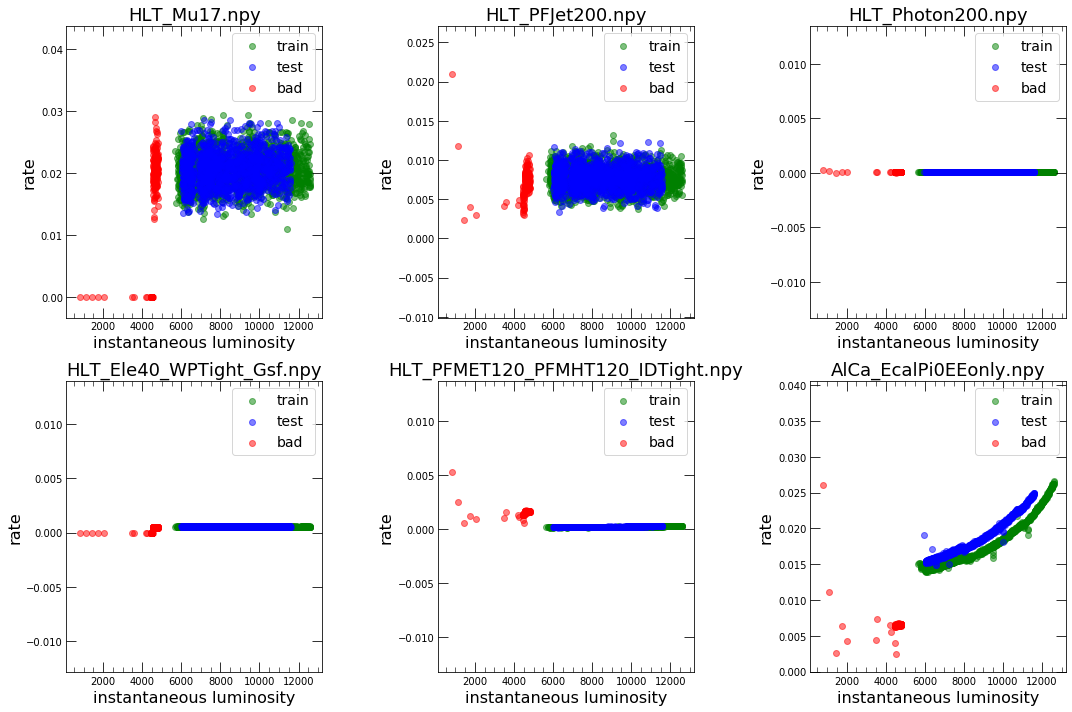

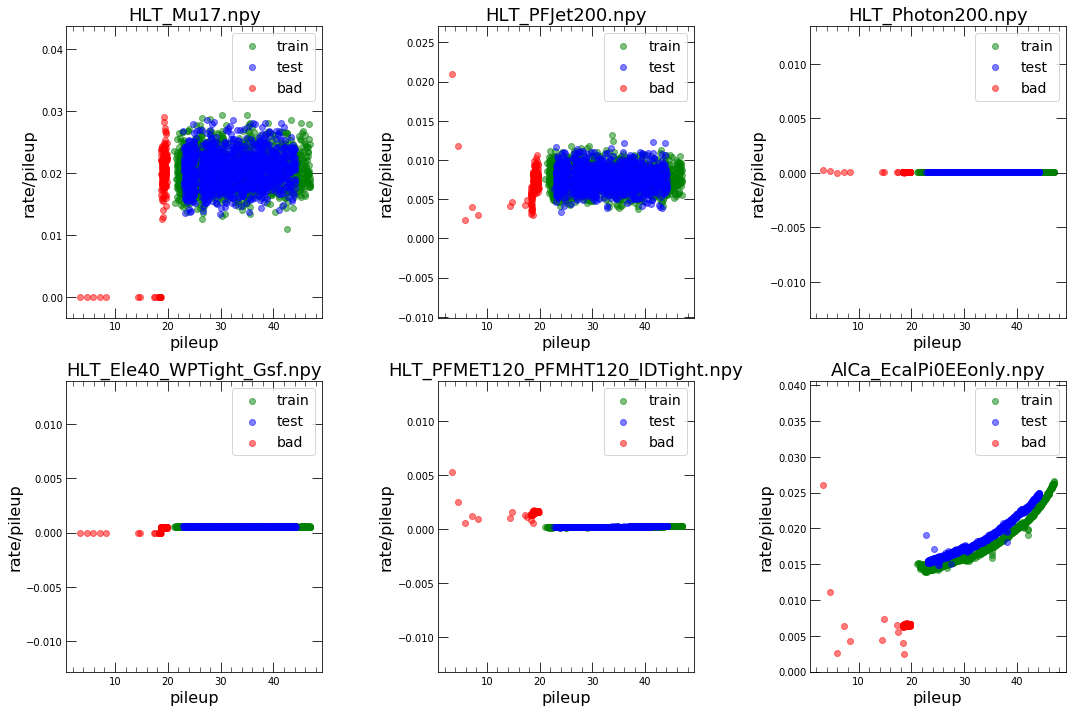

In [61]:
plots = [x_train,x_test,x_bad]
titles = ["train","test","bad"]

stuff = [[],[],[]]
lumi = [[],[],[]]
inst = [[],[],[]]
pileup = [[],[],[]]
for h in range(3):
    if h == 0 or h == 1:
        lumi[h] = data[str(runs[h])]['lumiid']
        inst[h] = data[str(runs[h])]['instlumi']
        pileup[h] = data[str(runs[h])]['pileup']
        stuff[h] = data[str(runs[h])]['rates']
    else:
        lumi[h] = bad_data["301480"]['lumiid']
        inst[h] = bad_data["301480"]['instlumi']
        pileup[h] = bad_data["301480"]['pileup']
        stuff[h] = bad_data["301480"]['rates']
    
labels = data['HLT'] 
colors = ["g","b","r"]
    
plt.figure(figsize=[15,10])
for i in range(num_parts):
    plt.subplot(2,3,i+1)
    for k in range(0,3):
        #print(len(i[k]),len(stuff[k][i]))
        plt.scatter(lumi[k],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.figure(figsize=[15,10])
              
for i in range(num_parts):
    plt.subplot(2,3,i+1)
    for k in range(0,3):
        #print(len(inst[k][i]),len(stuff[k][i]))
        plt.scatter(inst[k][i],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
    plt.xlabel('instantaneous luminosity')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.figure(figsize=[15,10])
              
for i in range(num_parts):
    plt.subplot(2,3,i+1)
    for k in range(0,3):
        #print(len(lumi[k]),len(stuff[k][i]))
        plt.scatter(pileup[k][i],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
    plt.xlabel('pileup')
    plt.ylabel('rate/pileup')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.show()

## Simple Autoencoder

In [75]:
model_name = "added_layer"


In [76]:
# Define the architecture

_input = Input(shape=(num_parts*WINDOW,), name="input")

mid = Dense(5,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation=None,
               name="mid1")(_input)

hidden = Dense(3,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation=None,
               name="encoded")(mid)

mid = Dense(5,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation=None,
               name="mid2")(hidden)

output = Dense(num_parts*WINDOW,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation=None,
               name="reconstructed")(mid)

model = Model(_input, output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
mid1 (Dense)                 (None, 5)                 35        
_________________________________________________________________
encoded (Dense)              (None, 3)                 18        
_________________________________________________________________
mid2 (Dense)                 (None, 5)                 20        
_________________________________________________________________
reconstructed (Dense)        (None, 6)                 36        
Total params: 109
Trainable params: 109
Non-trainable params: 0
_________________________________________________________________


Train on 1669 samples, validate on 1224 samples
Epoch 1/1000
 - 1s - loss: 12.0130 - val_loss: 12.1701
Epoch 2/1000
 - 0s - loss: 11.4475 - val_loss: 11.5947
Epoch 3/1000
 - 0s - loss: 10.9046 - val_loss: 11.0452
Epoch 4/1000
 - 0s - loss: 10.3889 - val_loss: 10.5212
Epoch 5/1000
 - 0s - loss: 9.8954 - val_loss: 10.0224
Epoch 6/1000
 - 0s - loss: 9.4262 - val_loss: 9.5481
Epoch 7/1000
 - 0s - loss: 8.9801 - val_loss: 9.0980
Epoch 8/1000
 - 0s - loss: 8.5579 - val_loss: 8.6711
Epoch 9/1000
 - 0s - loss: 8.1563 - val_loss: 8.2651
Epoch 10/1000
 - 0s - loss: 7.7752 - val_loss: 7.8827
Epoch 11/1000
 - 0s - loss: 7.4166 - val_loss: 7.5212
Epoch 12/1000
 - 0s - loss: 7.0767 - val_loss: 7.1797
Epoch 13/1000
 - 0s - loss: 6.7558 - val_loss: 6.8572
Epoch 14/1000
 - 0s - loss: 6.4534 - val_loss: 6.5527
Epoch 15/1000
 - 0s - loss: 6.1673 - val_loss: 6.2654
Epoch 16/1000
 - 0s - loss: 5.8976 - val_loss: 5.9927
Epoch 17/1000
 - 0s - loss: 5.6409 - val_loss: 5.7355
Epoch 18/1000
 - 0s - loss: 5.3997

Epoch 151/1000
 - 0s - loss: 0.3185 - val_loss: 0.3322
Epoch 152/1000
 - 0s - loss: 0.3147 - val_loss: 0.3283
Epoch 153/1000
 - 0s - loss: 0.3110 - val_loss: 0.3245
Epoch 154/1000
 - 0s - loss: 0.3074 - val_loss: 0.3207
Epoch 155/1000
 - 0s - loss: 0.3038 - val_loss: 0.3170
Epoch 156/1000
 - 0s - loss: 0.3003 - val_loss: 0.3134
Epoch 157/1000
 - 0s - loss: 0.2968 - val_loss: 0.3098
Epoch 158/1000
 - 0s - loss: 0.2934 - val_loss: 0.3063
Epoch 159/1000
 - 0s - loss: 0.2901 - val_loss: 0.3028
Epoch 160/1000
 - 0s - loss: 0.2868 - val_loss: 0.2994
Epoch 161/1000
 - 0s - loss: 0.2836 - val_loss: 0.2960
Epoch 162/1000
 - 0s - loss: 0.2804 - val_loss: 0.2927
Epoch 163/1000
 - 0s - loss: 0.2773 - val_loss: 0.2895
Epoch 164/1000
 - 0s - loss: 0.2742 - val_loss: 0.2863
Epoch 165/1000
 - 0s - loss: 0.2712 - val_loss: 0.2831
Epoch 166/1000
 - 0s - loss: 0.2682 - val_loss: 0.2800
Epoch 167/1000
 - 0s - loss: 0.2653 - val_loss: 0.2770
Epoch 168/1000
 - 0s - loss: 0.2624 - val_loss: 0.2740
Epoch 169/

Epoch 300/1000
 - 0s - loss: 0.0858 - val_loss: 0.0899
Epoch 301/1000
 - 0s - loss: 0.0853 - val_loss: 0.0893
Epoch 302/1000
 - 0s - loss: 0.0847 - val_loss: 0.0887
Epoch 303/1000
 - 0s - loss: 0.0841 - val_loss: 0.0881
Epoch 304/1000
 - 0s - loss: 0.0836 - val_loss: 0.0875
Epoch 305/1000
 - 0s - loss: 0.0830 - val_loss: 0.0870
Epoch 306/1000
 - 0s - loss: 0.0825 - val_loss: 0.0864
Epoch 307/1000
 - 0s - loss: 0.0819 - val_loss: 0.0858
Epoch 308/1000
 - 0s - loss: 0.0814 - val_loss: 0.0853
Epoch 309/1000
 - 0s - loss: 0.0808 - val_loss: 0.0847
Epoch 310/1000
 - 0s - loss: 0.0803 - val_loss: 0.0842
Epoch 311/1000
 - 0s - loss: 0.0798 - val_loss: 0.0836
Epoch 312/1000
 - 0s - loss: 0.0793 - val_loss: 0.0831
Epoch 313/1000
 - 0s - loss: 0.0788 - val_loss: 0.0825
Epoch 314/1000
 - 0s - loss: 0.0782 - val_loss: 0.0820
Epoch 315/1000
 - 0s - loss: 0.0777 - val_loss: 0.0815
Epoch 316/1000
 - 0s - loss: 0.0772 - val_loss: 0.0809
Epoch 317/1000
 - 0s - loss: 0.0767 - val_loss: 0.0804
Epoch 318/

Epoch 449/1000
 - 0s - loss: 0.0370 - val_loss: 0.0388
Epoch 450/1000
 - 0s - loss: 0.0368 - val_loss: 0.0386
Epoch 451/1000
 - 0s - loss: 0.0366 - val_loss: 0.0384
Epoch 452/1000
 - 0s - loss: 0.0365 - val_loss: 0.0383
Epoch 453/1000
 - 0s - loss: 0.0363 - val_loss: 0.0381
Epoch 454/1000
 - 0s - loss: 0.0361 - val_loss: 0.0379
Epoch 455/1000
 - 0s - loss: 0.0359 - val_loss: 0.0377
Epoch 456/1000
 - 0s - loss: 0.0358 - val_loss: 0.0375
Epoch 457/1000
 - 0s - loss: 0.0356 - val_loss: 0.0374
Epoch 458/1000
 - 0s - loss: 0.0354 - val_loss: 0.0372
Epoch 459/1000
 - 0s - loss: 0.0353 - val_loss: 0.0370
Epoch 460/1000
 - 0s - loss: 0.0351 - val_loss: 0.0368
Epoch 461/1000
 - 0s - loss: 0.0349 - val_loss: 0.0367
Epoch 462/1000
 - 0s - loss: 0.0348 - val_loss: 0.0365
Epoch 463/1000
 - 0s - loss: 0.0346 - val_loss: 0.0363
Epoch 464/1000
 - 0s - loss: 0.0344 - val_loss: 0.0361
Epoch 465/1000
 - 0s - loss: 0.0343 - val_loss: 0.0360
Epoch 466/1000
 - 0s - loss: 0.0341 - val_loss: 0.0358
Epoch 467/

Epoch 598/1000
 - 0s - loss: 0.0196 - val_loss: 0.0206
Epoch 599/1000
 - 0s - loss: 0.0195 - val_loss: 0.0205
Epoch 600/1000
 - 0s - loss: 0.0194 - val_loss: 0.0204
Epoch 601/1000
 - 0s - loss: 0.0194 - val_loss: 0.0203
Epoch 602/1000
 - 0s - loss: 0.0193 - val_loss: 0.0203
Epoch 603/1000
 - 0s - loss: 0.0192 - val_loss: 0.0202
Epoch 604/1000
 - 0s - loss: 0.0191 - val_loss: 0.0201
Epoch 605/1000
 - 0s - loss: 0.0191 - val_loss: 0.0200
Epoch 606/1000
 - 0s - loss: 0.0190 - val_loss: 0.0200
Epoch 607/1000
 - 0s - loss: 0.0189 - val_loss: 0.0199
Epoch 608/1000
 - 0s - loss: 0.0189 - val_loss: 0.0198
Epoch 609/1000
 - 0s - loss: 0.0188 - val_loss: 0.0197
Epoch 610/1000
 - 0s - loss: 0.0187 - val_loss: 0.0197
Epoch 611/1000
 - 0s - loss: 0.0186 - val_loss: 0.0196
Epoch 612/1000
 - 0s - loss: 0.0186 - val_loss: 0.0195
Epoch 613/1000
 - 0s - loss: 0.0185 - val_loss: 0.0194
Epoch 614/1000
 - 0s - loss: 0.0184 - val_loss: 0.0194
Epoch 615/1000
 - 0s - loss: 0.0184 - val_loss: 0.0193
Epoch 616/

Epoch 747/1000
 - 0s - loss: 0.0116 - val_loss: 0.0122
Epoch 748/1000
 - 0s - loss: 0.0116 - val_loss: 0.0122
Epoch 749/1000
 - 0s - loss: 0.0116 - val_loss: 0.0121
Epoch 750/1000
 - 0s - loss: 0.0115 - val_loss: 0.0121
Epoch 751/1000
 - 0s - loss: 0.0115 - val_loss: 0.0121
Epoch 752/1000
 - 0s - loss: 0.0115 - val_loss: 0.0120
Epoch 753/1000
 - 0s - loss: 0.0114 - val_loss: 0.0120
Epoch 754/1000
 - 0s - loss: 0.0114 - val_loss: 0.0120
Epoch 755/1000
 - 0s - loss: 0.0113 - val_loss: 0.0119
Epoch 756/1000
 - 0s - loss: 0.0113 - val_loss: 0.0119
Epoch 757/1000
 - 0s - loss: 0.0113 - val_loss: 0.0118
Epoch 758/1000
 - 0s - loss: 0.0112 - val_loss: 0.0118
Epoch 759/1000
 - 0s - loss: 0.0112 - val_loss: 0.0118
Epoch 760/1000
 - 0s - loss: 0.0112 - val_loss: 0.0117
Epoch 761/1000
 - 0s - loss: 0.0111 - val_loss: 0.0117
Epoch 762/1000
 - 0s - loss: 0.0111 - val_loss: 0.0117
Epoch 763/1000
 - 0s - loss: 0.0111 - val_loss: 0.0116
Epoch 764/1000
 - 0s - loss: 0.0110 - val_loss: 0.0116
Epoch 765/

Epoch 896/1000
 - 0s - loss: 0.0074 - val_loss: 0.0078
Epoch 897/1000
 - 0s - loss: 0.0074 - val_loss: 0.0078
Epoch 898/1000
 - 0s - loss: 0.0074 - val_loss: 0.0078
Epoch 899/1000
 - 0s - loss: 0.0074 - val_loss: 0.0077
Epoch 900/1000
 - 0s - loss: 0.0074 - val_loss: 0.0077
Epoch 901/1000
 - 0s - loss: 0.0073 - val_loss: 0.0077
Epoch 902/1000
 - 0s - loss: 0.0073 - val_loss: 0.0077
Epoch 903/1000
 - 0s - loss: 0.0073 - val_loss: 0.0077
Epoch 904/1000
 - 0s - loss: 0.0073 - val_loss: 0.0076
Epoch 905/1000
 - 0s - loss: 0.0072 - val_loss: 0.0076
Epoch 906/1000
 - 0s - loss: 0.0072 - val_loss: 0.0076
Epoch 907/1000
 - 0s - loss: 0.0072 - val_loss: 0.0076
Epoch 908/1000
 - 0s - loss: 0.0072 - val_loss: 0.0076
Epoch 909/1000
 - 0s - loss: 0.0072 - val_loss: 0.0075
Epoch 910/1000
 - 0s - loss: 0.0071 - val_loss: 0.0075
Epoch 911/1000
 - 0s - loss: 0.0071 - val_loss: 0.0075
Epoch 912/1000
 - 0s - loss: 0.0071 - val_loss: 0.0075
Epoch 913/1000
 - 0s - loss: 0.0071 - val_loss: 0.0074
Epoch 914/

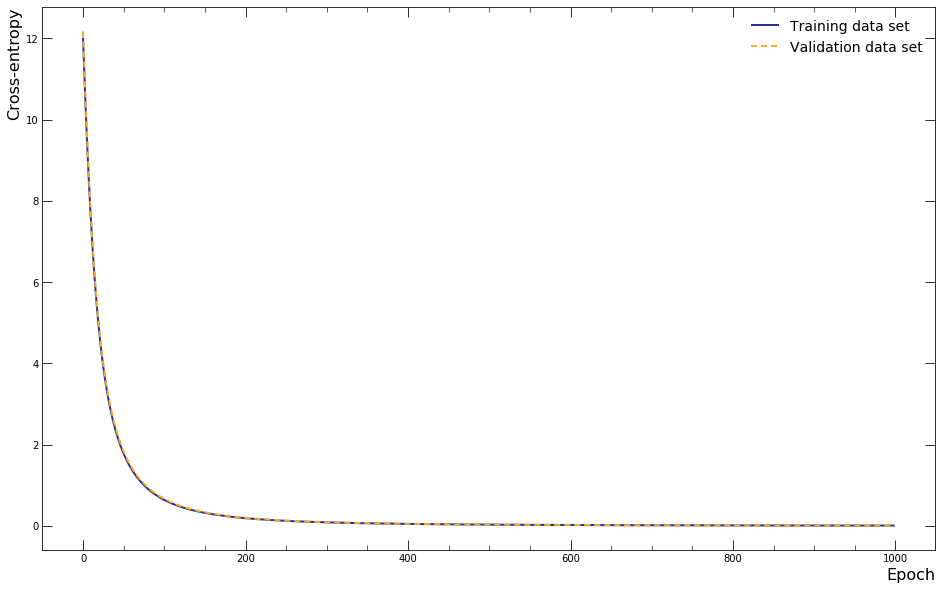

In [77]:
# Train neural networks
history = train_nn(model, x_train, x_train, 1024, "mse", model_name, x_val).history
plot_loss(history)

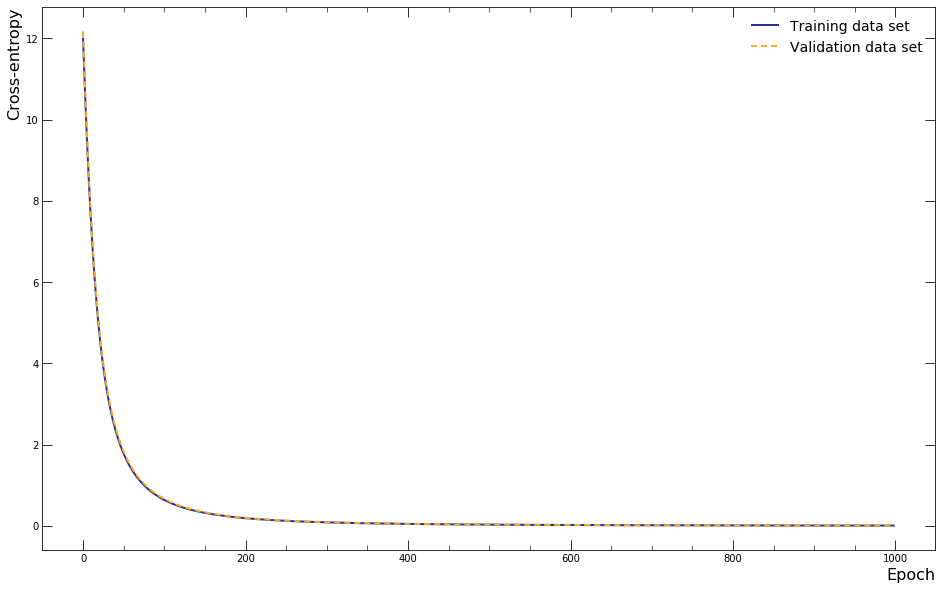

In [78]:
plot_loss(history)

## Training Set

In [79]:
# Generate predictions

model = load_model("%s.h5" % (model_name))

x_train_new = []
lumi_new = []
lumi = data[str(runs[0])]['lumiid'] 

for l in range(len(x_train)):
    if not 0 in x_train[l]:
        x_train_new.append(x_train[l])
        for i in range(WINDOW):
            lumi_new.append(lumi[l+i])
                
reconstructed = model.predict(np.array(x_train_new))

error = (x_train_new-reconstructed)/x_train_new

In [80]:
error_reformat = []
for i in range(num_parts):
    error_reformat.append([])

for i in range(len(error)):
    for j in range(num_parts):
        if i == len(error)-1:
            for val in error[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat[j].append(val)
        else:
            error_reformat[j].append(error[i][WINDOW*j])
            
inp = []
outp = []
for i in range(num_parts):
    inp.append([])
    outp.append([])
    
for i in range(len(reconstructed)):
    for j in range(num_parts):
        if i == len(reconstructed)-1:
            for val in reconstructed[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp[j].append(val)
            for val in x_train_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp[j].append(val)
        else:
            outp[j].append(reconstructed[i][WINDOW*j])
            inp[j].append(x_train_new[i][WINDOW*j])

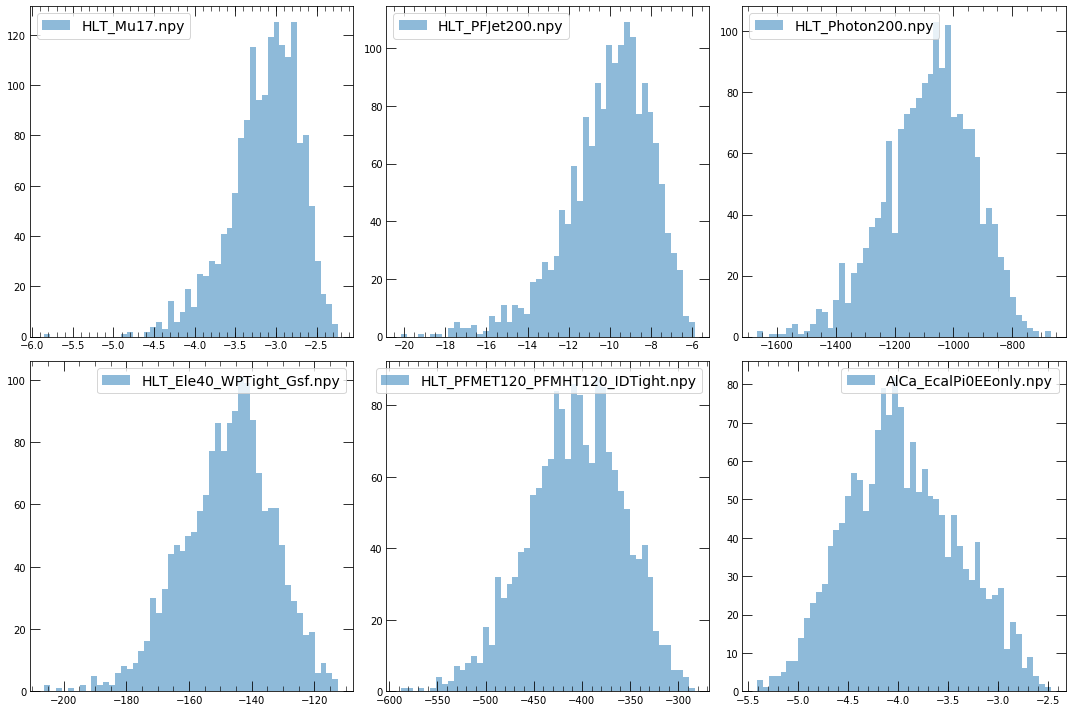

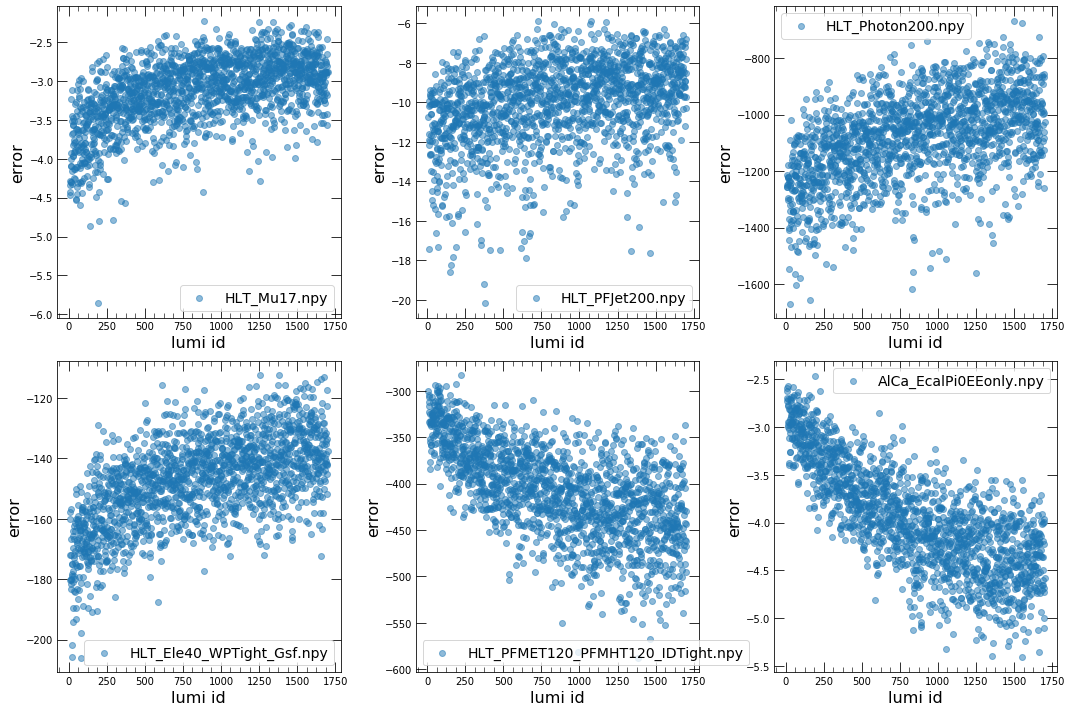

In [81]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[15,10])
for i in range(len(error_reformat)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label=labels[i],alpha=.5)
    plt.legend()
plt.tight_layout()

#lumi = np.linspace(0,len(error_reformat[0]),len(error_reformat[0]))
plt.figure(figsize=[15,10])
for i in range(0,num_parts):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label=labels[i],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
plt.tight_layout()

plt.show()

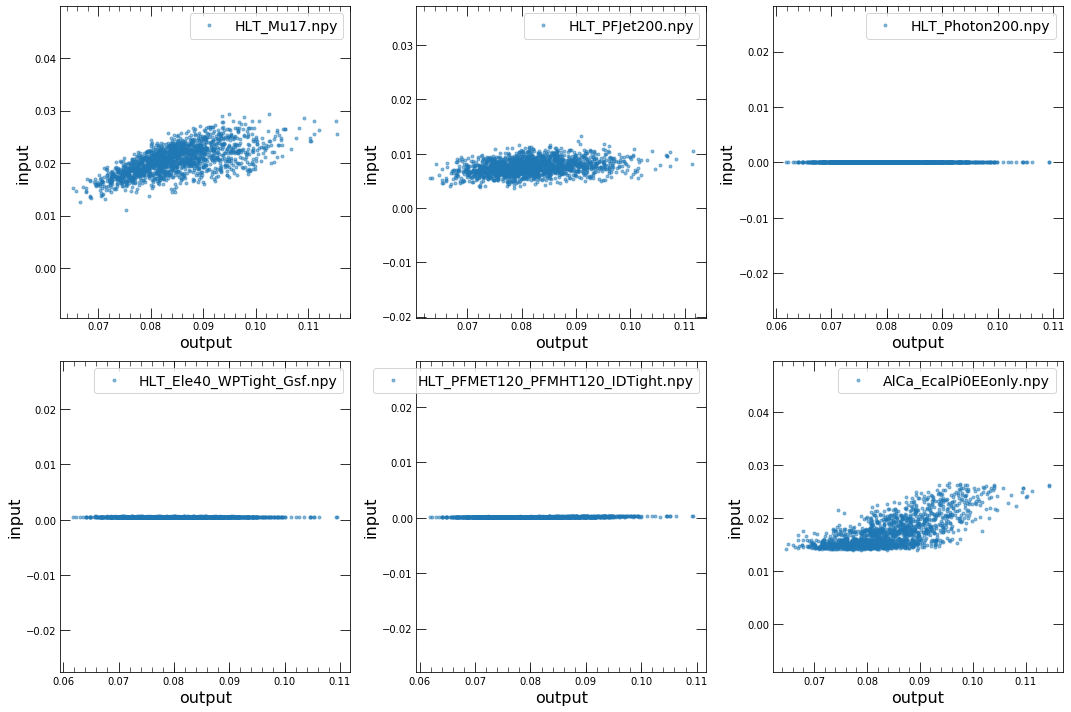

In [82]:
plt.figure(figsize=[15,10])
for i in range(0,num_parts):
    plt.subplot(2,3,i+1)
    plt.plot(outp[i],inp[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    #plt.scatter(lumi,outp[i],label='output',alpha=.5)
    plt.xlabel('output')
    plt.ylabel('input')
    plt.axis('equal')
    #plt.ylim(0,1.8)
    plt.legend()    
plt.tight_layout()
plt.show()

## Test Data

In [83]:
# Generate predictions

model = load_model("%s.h5" % (model_name))

x_test_new = []
for l in x_test:
    if not 0 in l:
        x_test_new.append(l)
                
reconstructed = model.predict(np.array(x_test_new))

error = (x_test_new-reconstructed)/x_test_new

In [84]:
error_reformat = []
for i in range(num_parts):
    error_reformat.append([])

for i in range(len(error)):
    for j in range(num_parts):
        if i == len(error)-1:
            for val in error[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat[j].append(val)
        else:
            error_reformat[j].append(error[i][WINDOW*j])
            
inp = []
outp = []
for i in range(num_parts):
    inp.append([])
    outp.append([])
    
for i in range(len(reconstructed)):
    for j in range(num_parts):
        if i == len(reconstructed)-1:
            for val in reconstructed[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp[j].append(val)
            for val in x_test_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp[j].append(val)
        else:
            outp[j].append(reconstructed[i][WINDOW*j])
            inp[j].append(x_test_new[i][WINDOW*j])

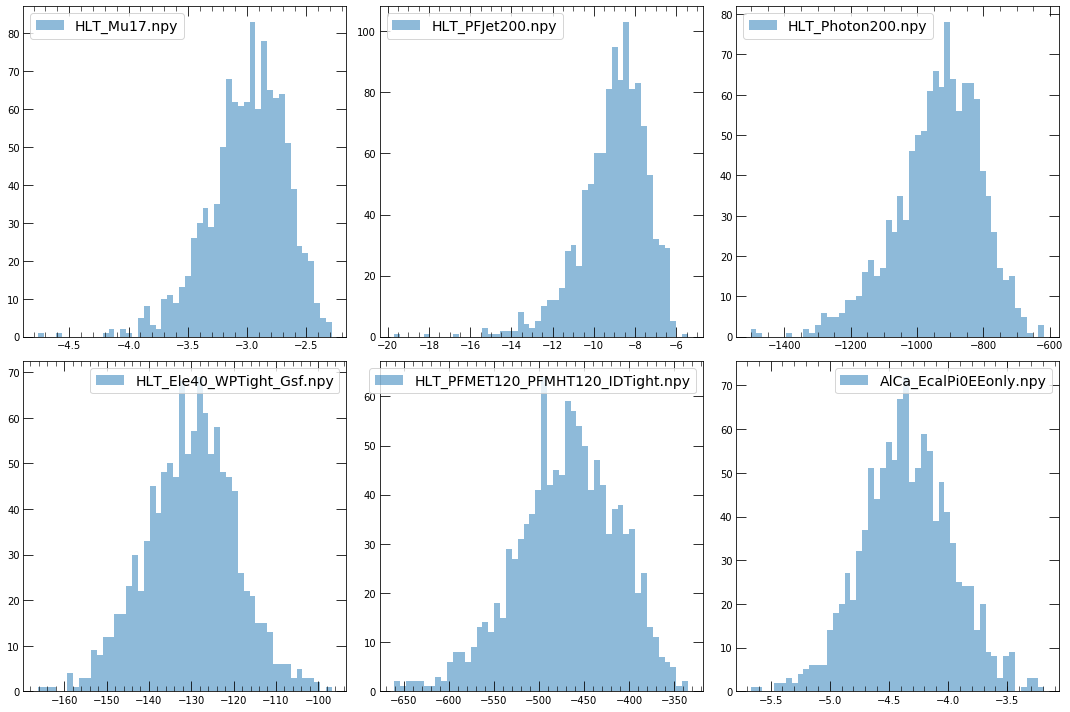

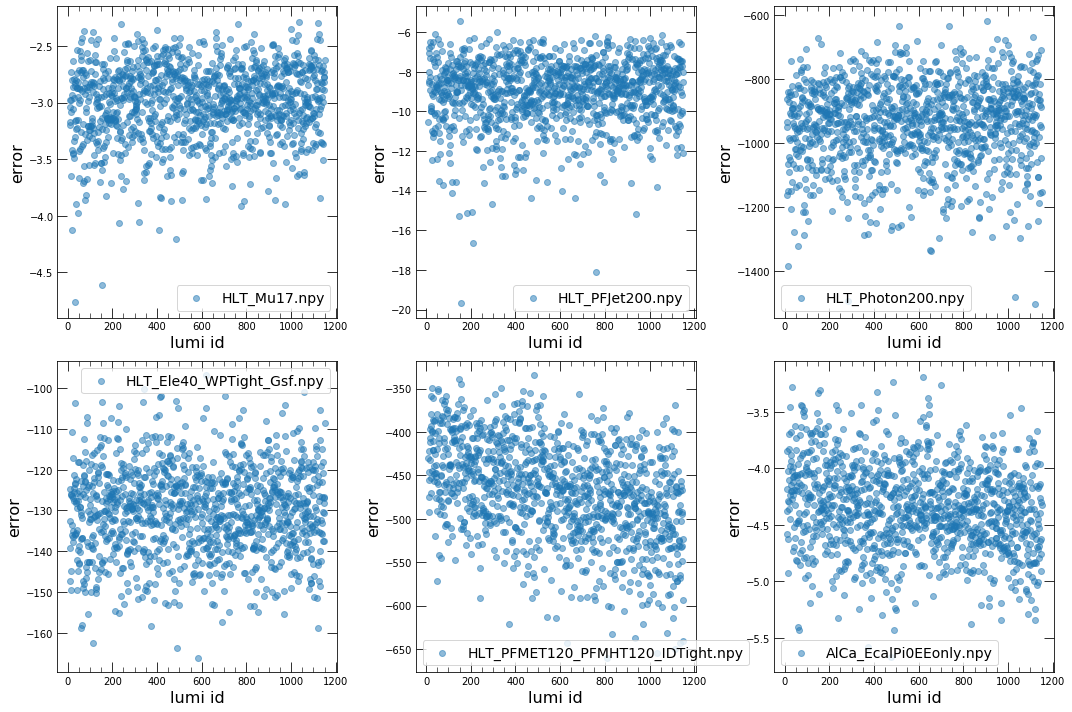

In [85]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[15,10])
for i in range(len(error_reformat)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label=labels[i],alpha=.5)
    plt.legend()
    
plt.tight_layout()

lumi = data[str(runs[2])]['lumiid'] 
#lumi = np.linspace(0,len(error_reformat[0]),len(error_reformat[0]))
plt.figure(figsize=[15,10])
for i in range(0,num_parts):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label=labels[i],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()   
plt.tight_layout()

plt.show()

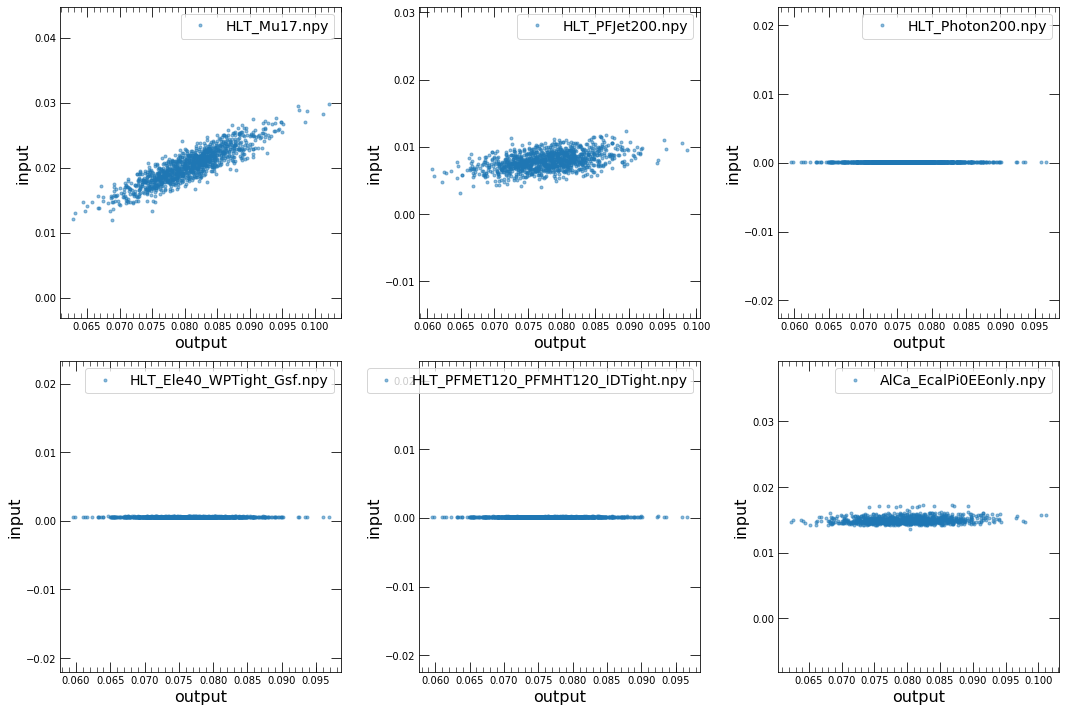

In [86]:
plt.figure(figsize=[15,10])
for i in range(0,num_parts):
    plt.subplot(2,3,i+1)
    plt.plot(outp[i],inp[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    #plt.scatter(lumi,outp[i],label='output',alpha=.5)
    plt.xlabel('output')
    plt.ylabel('input')
    plt.axis('equal')
    #plt.xlim(0,1.8)
    #plt.ylim(0,1.8)
    plt.legend()    
    
plt.tight_layout()

plt.show()

In [87]:
# plt.figure(figsize=[20,10])
# for i in range(0,4):
#     plt.subplot(2,2,i+1)
#     plt.scatter(lumi,inp[i],label='input',alpha=.5)
#     plt.scatter(lumi,outp[i]/max(outp[i]),label='output',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [88]:
# for i in range(len(outp)):
#     for j in range(i+1,len(outp)):
#         print(sum(np.array(outp[i]/max(outp[i]))-np.array(outp[j]/max(outp[j]))))

## Fake Bad Data

In [29]:
bad = np.array(data[str(runs[2])]['bad_samples'])

In [30]:
bad_new = []
for l in bad:
    if not 0 in l:
        bad_new.append(l)
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [31]:
error_reformat_bad = []
for i in range(num_parts):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(num_parts):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(num_parts):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(num_parts):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

1129 1129


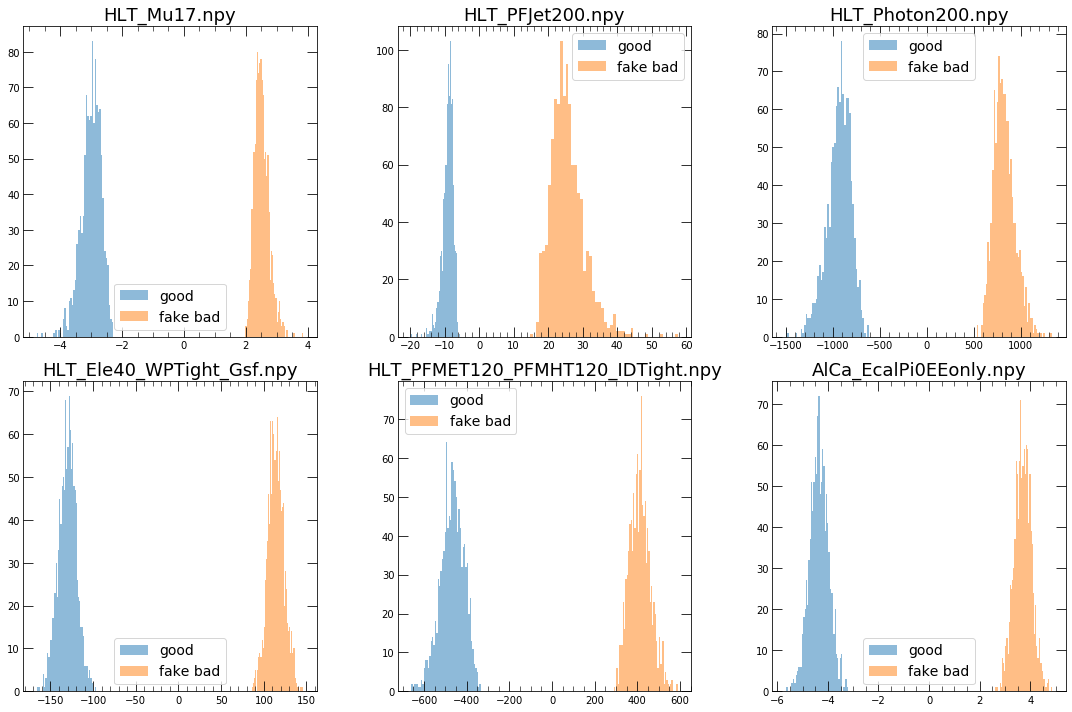

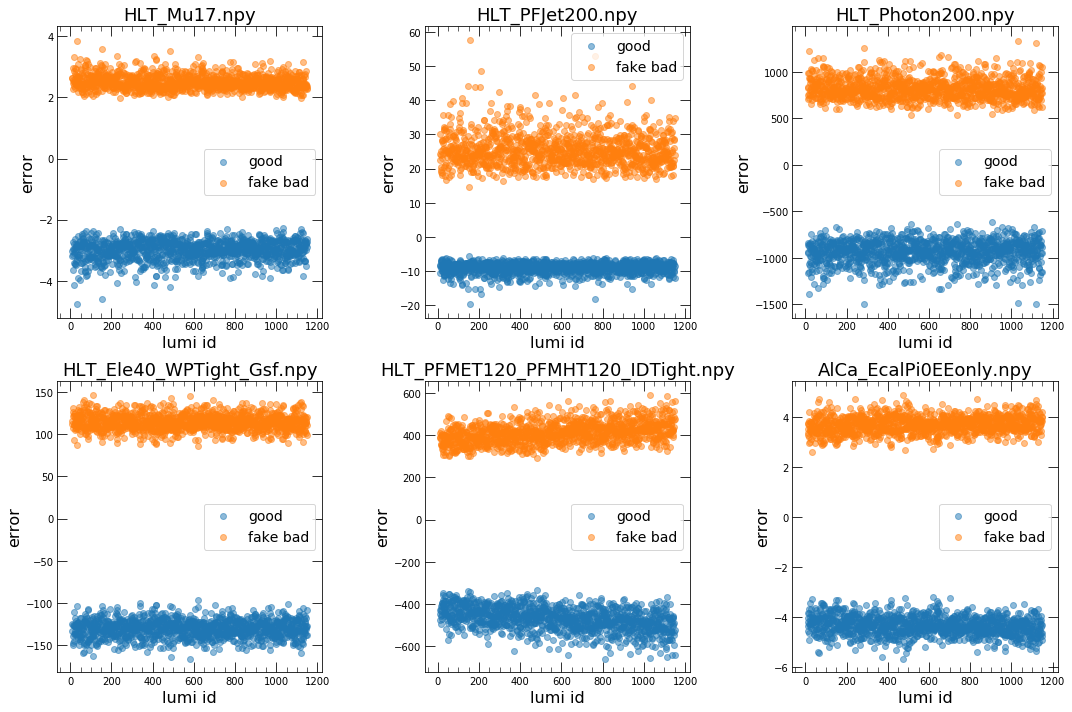

In [32]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[15,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='fake bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])
    
plt.tight_layout()

lumi = data[str(runs[2])]['lumiid'] 
print(len(error_reformat_bad[0]),len(lumi))
#lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
plt.figure(figsize=[15,10])
for i in range(0,num_parts):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumi,error_reformat_bad[i],label='fake bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])
    
plt.tight_layout()

plt.show()

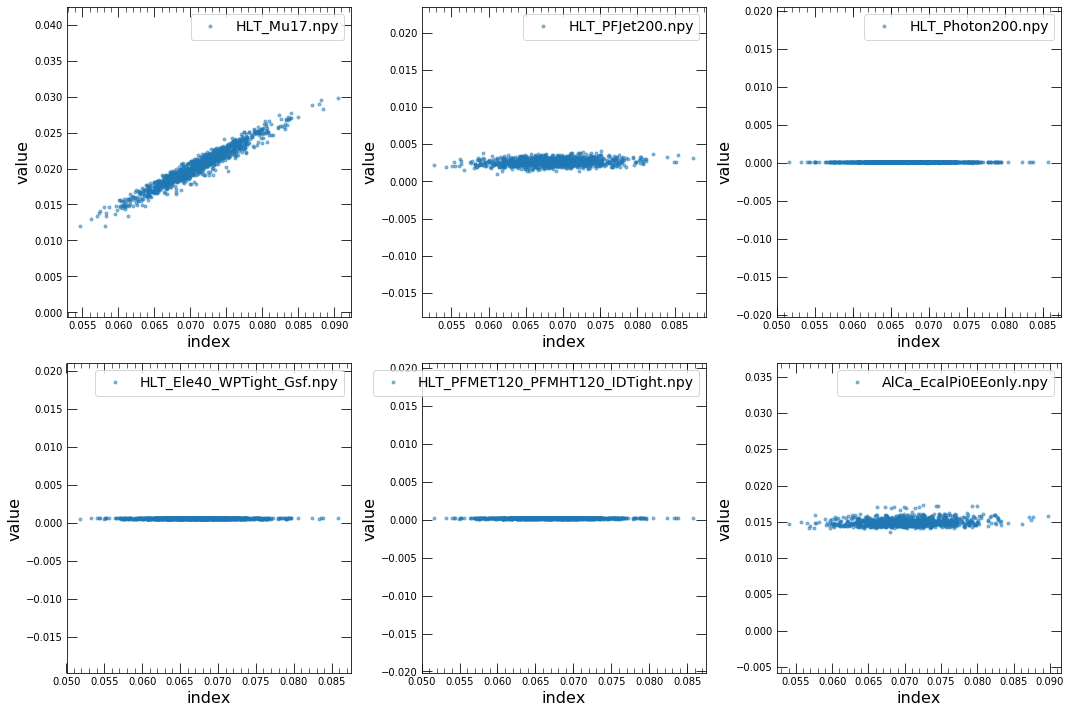

In [33]:
plt.figure(figsize=[15,10])
for i in range(0,num_parts):
    plt.subplot(2,3,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('index')
    plt.ylabel('value')
    plt.axis('equal')
    #plt.xlim(0,2)
    #plt.ylim(0,2)
    plt.legend()  
    
plt.tight_layout()

plt.show()

In [34]:
# plt.figure(figsize=[20,10])
# for i in range(0,4):
#     plt.subplot(2,2,i+1)
#     plt.scatter(lumi,inp_bad[i],label='inp_badut',alpha=.5)
#     plt.scatter(lumi,outp_bad[i]/max(outp_bad[i]),label='outp_badut',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [35]:
# labels = data['HLT']

# #bins = np.linspace(0,1,50)
# bins = 50
# plt.figure(figsize=[20,10])
# for i in range(len(error_reformat_bad)):
#     plt.subplot(2,2,i+1)
#     plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
#     plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
#     plt.legend()

# # lumi = data[str(runs[0])]['lumiid'] 
# # print(len(error_reformat_bad[0]),len(lumi))
# # #lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
# # plt.figure(figsize=[20,10])
# # for i in range(0,4):
# #     plt.subplot(2,2,i+1)
# #     plt.scatter(lumi,error_reformat_bad[i],label='bad',alpha=.5)
# #     plt.scatter(lumi,error_reformat[i],label='good',alpha=.5)
# #     plt.xlabel('lumi id')
# #     plt.ylabel('error')
# #     plt.legend()    

# plt.show()

## Fake Bad Data - ALL

In [36]:
bad = np.array(data[str(runs[2])]['all_bad_samples'])

In [37]:
bad_new = []
for l in bad:
    if not 0 in l:
        bad_new.append(l)
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [38]:
error_reformat_bad = []
for i in range(num_parts):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(num_parts):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(num_parts):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(num_parts):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

1129 1129


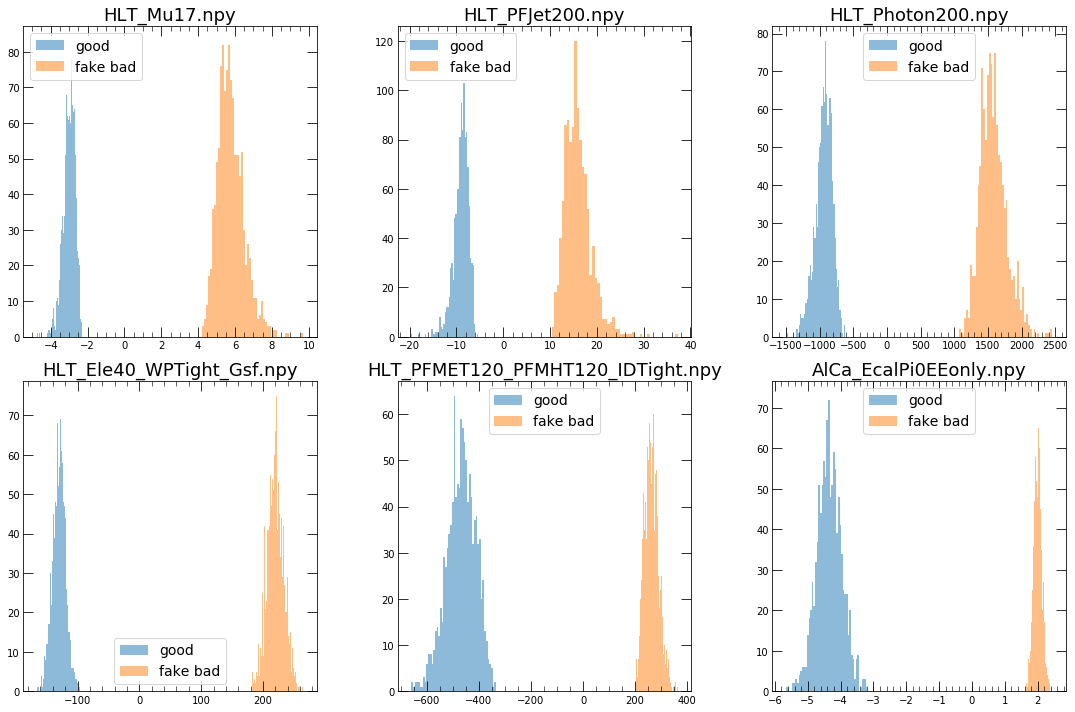

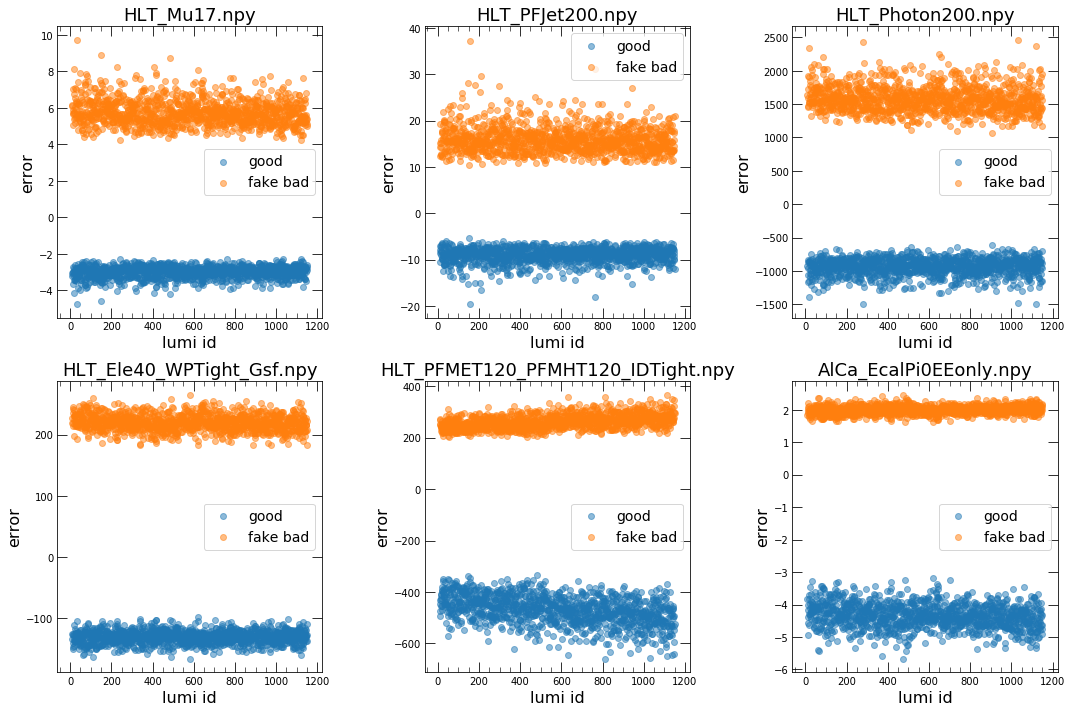

In [39]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[15,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='fake bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])
    
plt.tight_layout()

lumi = data[str(runs[2])]['lumiid'] 
print(len(error_reformat_bad[0]),len(lumi))
#lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
plt.figure(figsize=[15,10])
for i in range(0,num_parts):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumi,error_reformat_bad[i],label='fake bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])
    
plt.tight_layout()

plt.show()

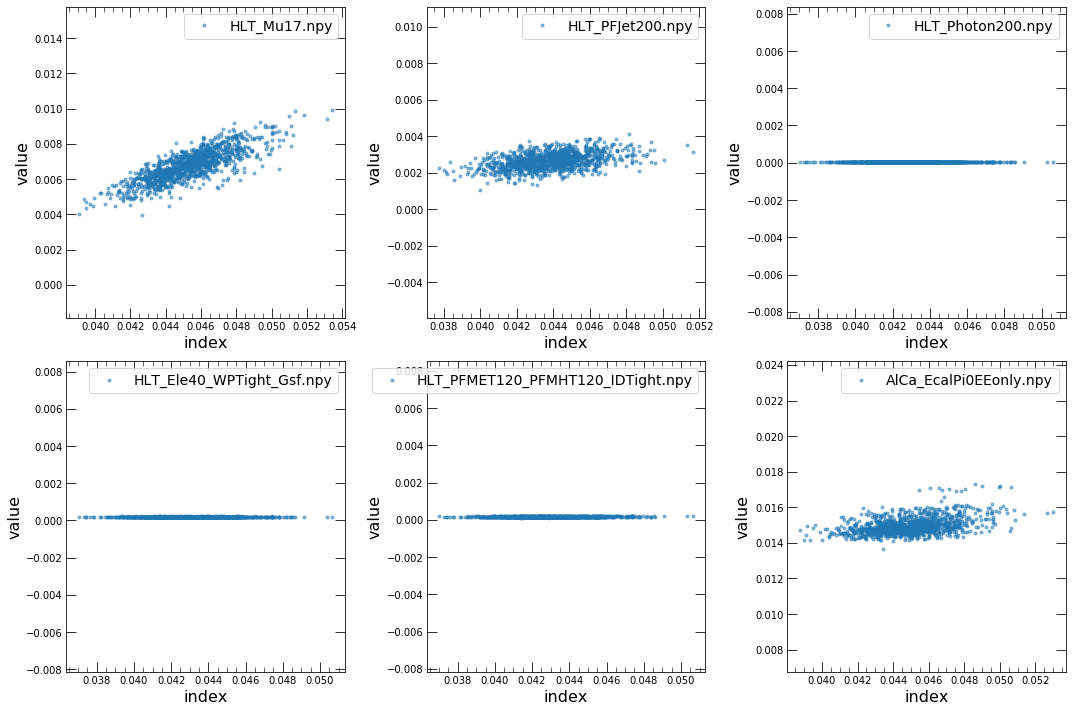

In [40]:
plt.figure(figsize=[15,10])
for i in range(0,num_parts):
    plt.subplot(2,3,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('index')
    plt.ylabel('value')
    plt.axis('equal')
    #plt.xlim(0,.6)
    #plt.ylim(0,.6)
    plt.legend()  
    
plt.tight_layout()

plt.show()

In [41]:
# plt.figure(figsize=[20,10])
# for i in range(0,4):
#     plt.subplot(2,2,i+1)
#     plt.scatter(lumi,inp_bad[i],label='input',alpha=.5)
#     plt.scatter(lumi,outp_bad[i]/max(outp_bad[i]),label='output',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [42]:
# labels = data['HLT']

# #bins = np.linspace(0,1,50)
# bins = 50
# plt.figure(figsize=[20,10])
# for i in range(len(error_reformat_bad)):
#     plt.subplot(2,2,i+1)
#     plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
#     plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
#     plt.legend()

# # lumi = data[str(runs[0])]['lumiid'] 
# # print(len(error_reformat_bad[0]),len(lumi))
# # #lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
# # plt.figure(figsize=[20,10])
# # for i in range(0,4):
# #     plt.subplot(2,2,i+1)
# #     plt.scatter(lumi,error_reformat_bad[i],label='bad',alpha=.5)
# #     plt.scatter(lumi,error_reformat[i],label='good',alpha=.5)
# #     plt.xlabel('lumi id')
# #     plt.ylabel('error')
# #     plt.legend()    

# plt.show()

## Real Bad Data

In [43]:
bad_runs = [301480]

with open("pileup_bad_dataNotNorm.pickle", 'rb') as handle:
    baddata = pickle.load(handle)

x_test = np.array(baddata[str(bad_runs[0])]['samples'])

In [44]:
bad_new = []
lumi_new = []

lumiBad = baddata[str(bad_runs[0])]['lumiid']

for l in range(len(x_test)):
    if not 0 in x_test[l]:
        bad_new.append(x_test[l])
        for i in range(WINDOW):
            lumi_new.append(lumiBad[l+i])
            
lumiBad = []
for n in lumi_new:
    if n not in lumiBad:
        lumiBad.append(n)
    
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [45]:
error_reformat_bad = []
for i in range(num_parts):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(num_parts):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(num_parts):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(num_parts):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

154 154


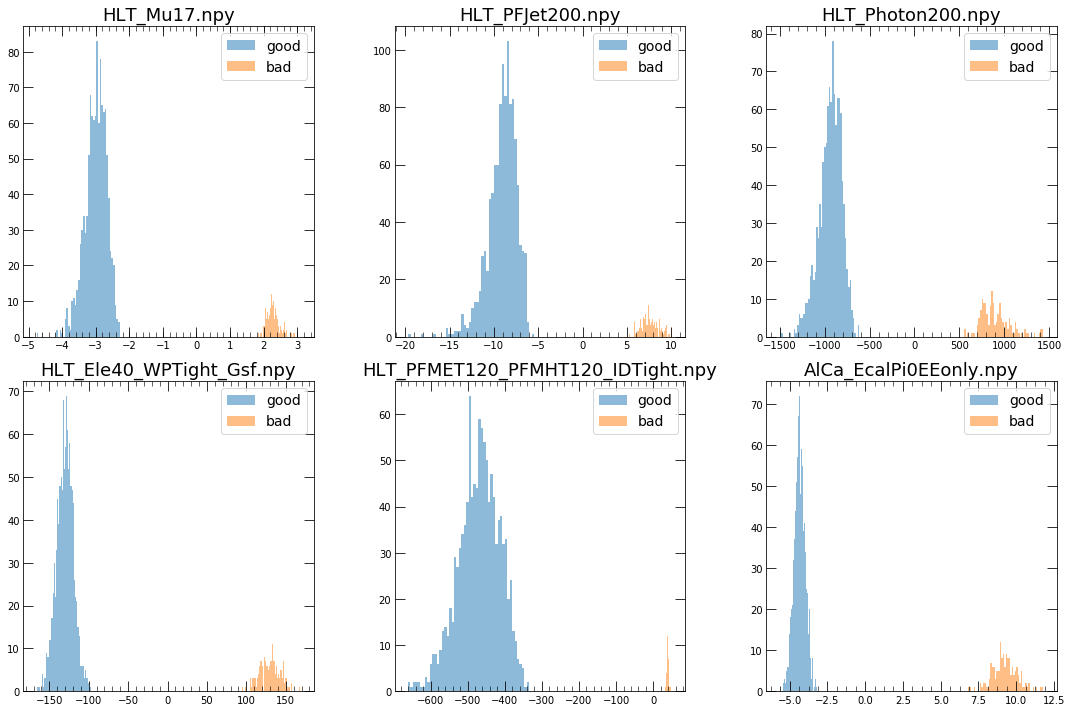

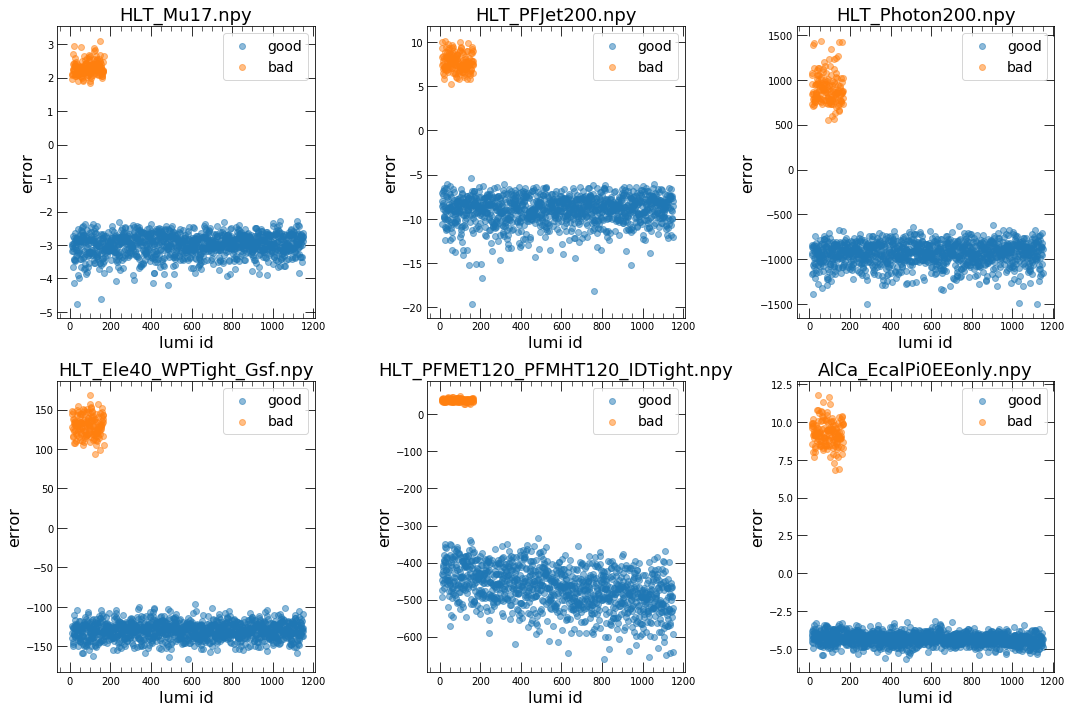

In [46]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[15,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])
plt.tight_layout()

print(len(error_reformat_bad[0]),len(lumiBad))
plt.figure(figsize=[15,10])
for i in range(0,num_parts):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumiBad,error_reformat_bad[i],label='bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])
plt.tight_layout()

plt.show()

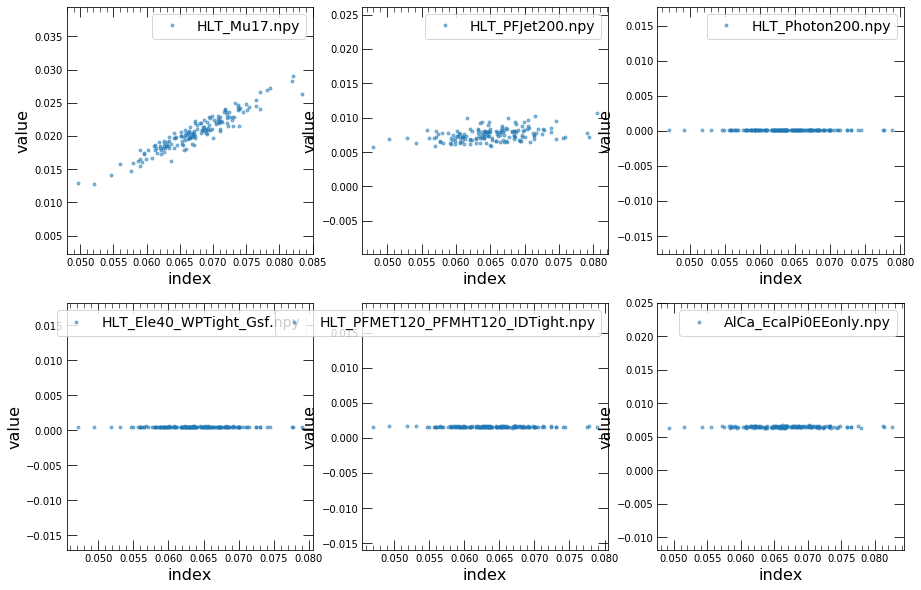

In [47]:
plt.figure(figsize=[15,10])
for i in range(0,num_parts):
    plt.subplot(2,3,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('index')
    plt.ylabel('value')
    plt.axis('equal')
    #plt.ylim(0,.6)
    plt.legend()    

plt.show()

## Real Bad Data

In [48]:
bad_runs = [305588]

with open("pileup_bad_dataNotNorm.pickle", 'rb') as handle:
    baddata = pickle.load(handle)

x_test = np.array(baddata[str(bad_runs[0])]['samples'])

In [49]:
bad_new = []
lumi_new = []

lumiBad = baddata[str(bad_runs[0])]['lumiid']

for l in range(len(x_test)):
    if not 0 in x_test[l]:
        bad_new.append(x_test[l])
        for i in range(WINDOW):
            lumi_new.append(lumiBad[l+i])
            
lumiBad = []
for n in lumi_new:
    if n not in lumiBad:
        lumiBad.append(n)
    
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [50]:
error_reformat_bad = []
for i in range(num_parts):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(num_parts):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(num_parts):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(num_parts):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

99 99


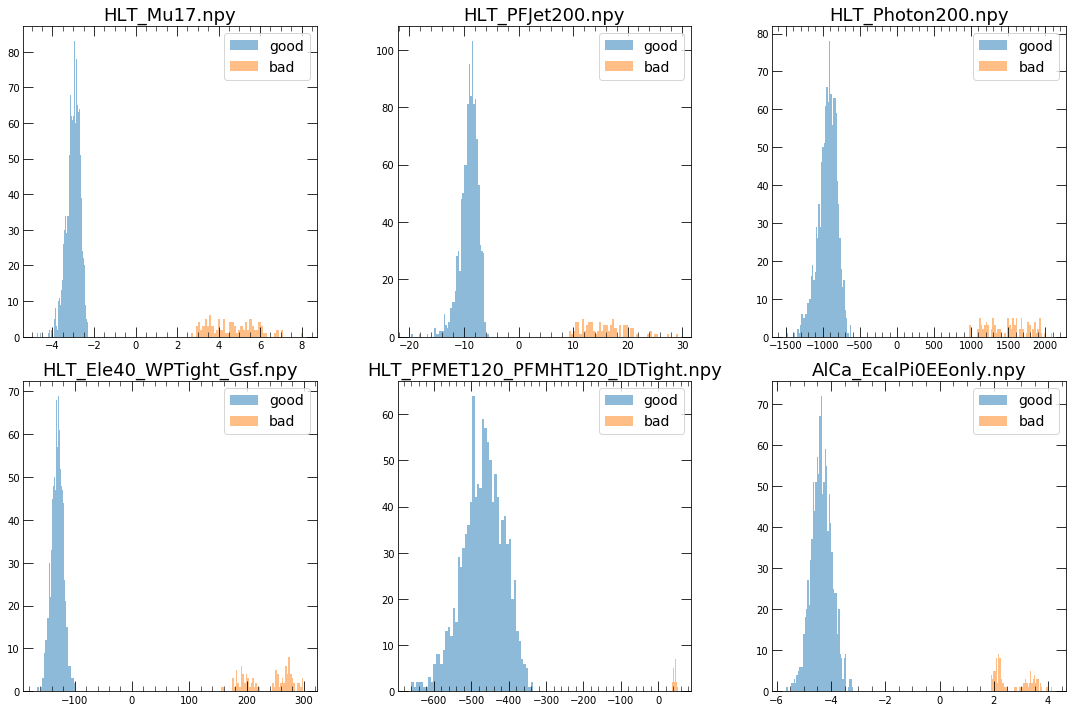

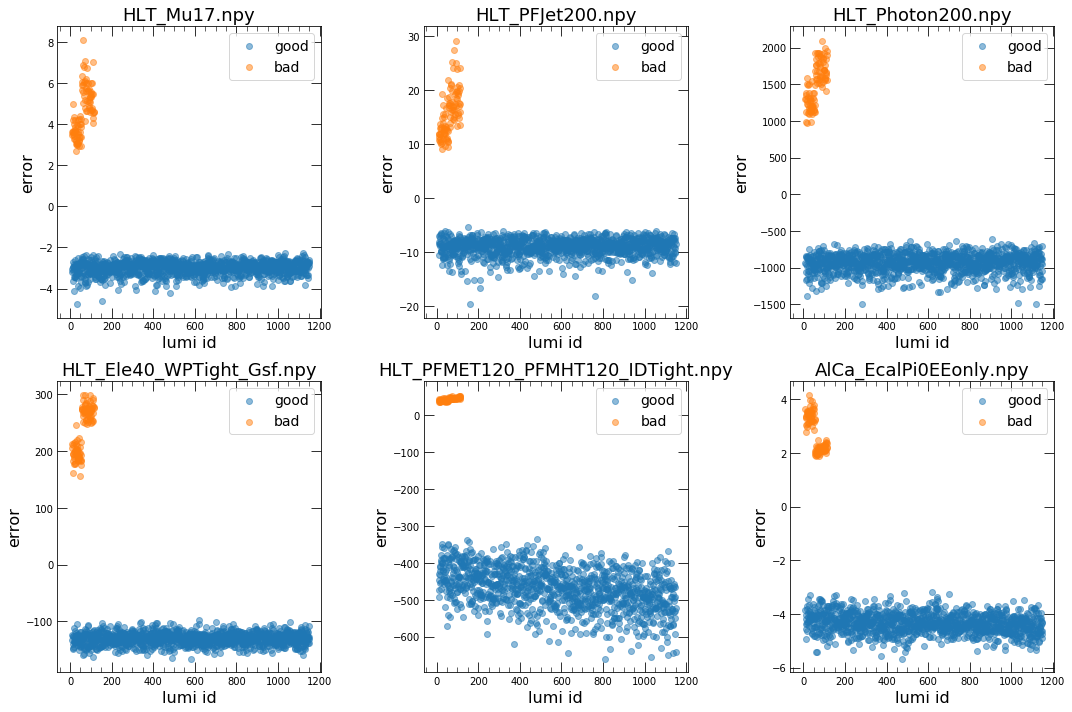

In [51]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[15,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])
plt.tight_layout()

print(len(error_reformat_bad[0]),len(lumiBad))
plt.figure(figsize=[15,10])
for i in range(0,num_parts):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumiBad,error_reformat_bad[i],label='bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])
plt.tight_layout()

plt.show()

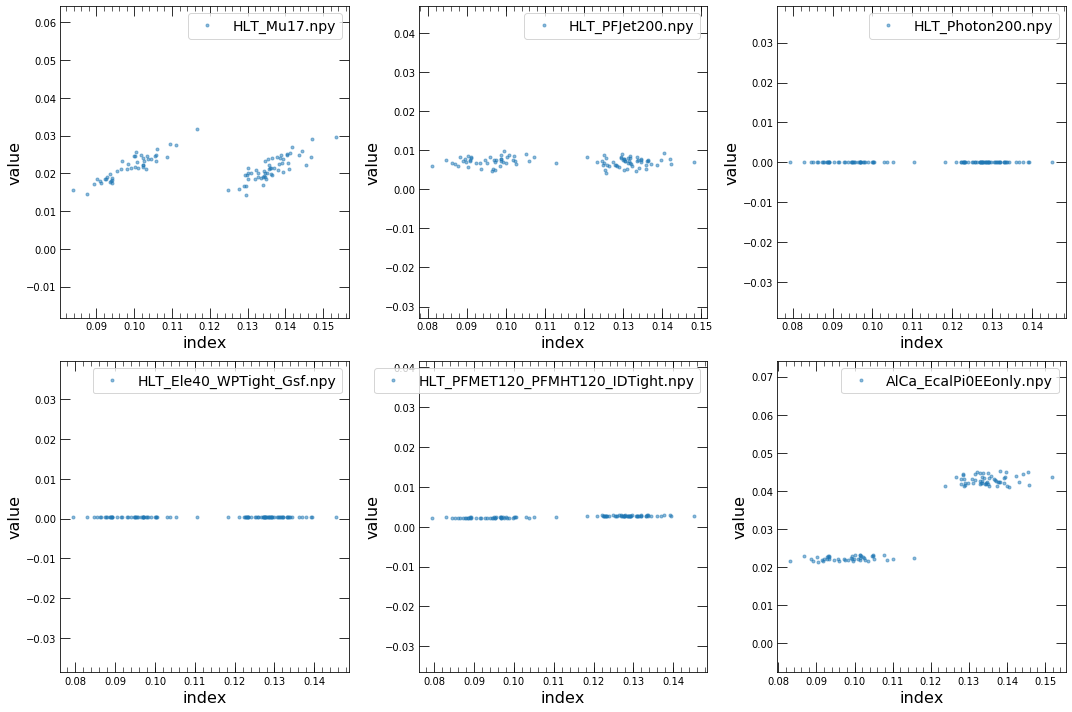

In [52]:
plt.figure(figsize=[15,10])
for i in range(0,num_parts):
    plt.subplot(2,3,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('index')
    plt.ylabel('value')
    plt.axis('equal')
    #plt.ylim(0,.6)
    plt.legend()   
plt.tight_layout()

plt.show()